In [1]:
# Imports.
import numpy as np
import matplotlib.pyplot as plt
import csv

from mpl_toolkits.mplot3d import Axes3D

# 1. Part one

## 1.1 Required functions.

In [2]:
# Loading data.
def load_data():
    filename = 'MI_timesteps.txt'
    with open(filename, newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=' ')
        next(reader)
        rows = []
        for row in reader:
            rows.append(row)
        return rows

# Visualizing data.
def plot_data(data, col):
    plt.figure(figsize=(10,7))
    plt.xlabel('t')
    plt.ylabel('x_i')
    plt.yticks([],[])
    plt.plot(range(data.shape[0]), data[:,col])
    plt.show()

# Delay embedding.
def del_emb(data, col):
    steps = data.shape[0]
    delays = 350

    P_list = []
    for i in range(steps - delays):
        p = []
        for j in range(delays):
            p.append(data[i+j, col])
        P_list.append(p)
    
    return np.array(P_list)

## 1.2 Loading and visualizing the data

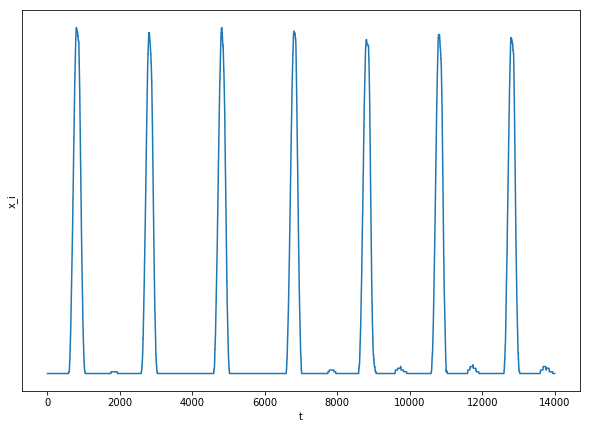

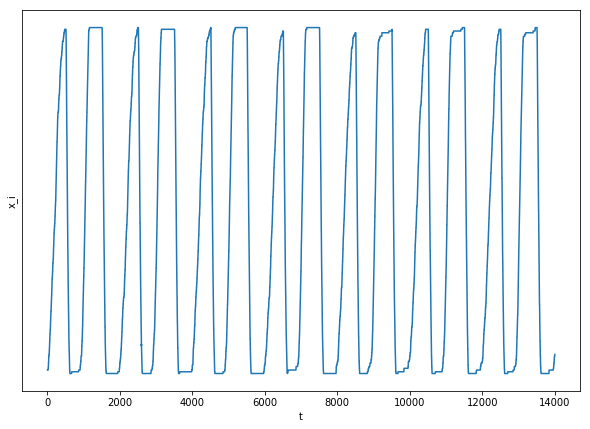

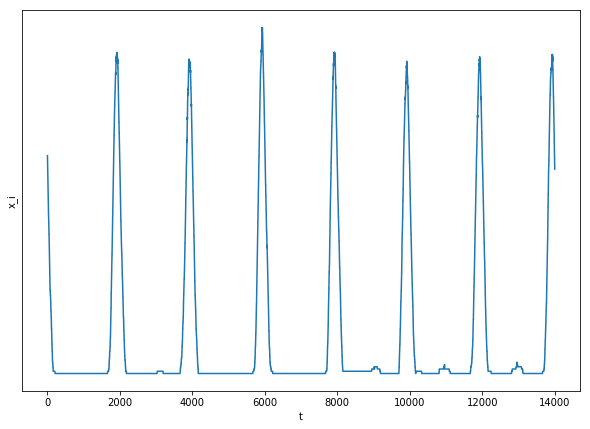

In [3]:
# Load data, remove burn-in period and data visualization.
data_list = load_data()
data = np.array(data_list)
data = data.astype(np.float)
data = data[1000:]

cols = [1,2,3]

for col in cols:
    plot_data(data, col)

## 1.3 PCA

In [4]:
P1 = del_emb(data, 1)
P2 = del_emb(data, 2)
P3 = del_emb(data, 3)

#Center data.
P1 = P1 - P1.mean(axis=0)
P2 = P2 - P2.mean(axis=0)
P3 = P3 - P3.mean(axis=0)

# Apply SVD on the data matrix.
u1, s1, vh1 = np.linalg.svd(P1, 0)
u2, s2, vh2 = np.linalg.svd(P2, 0)
u3, s3, vh3 = np.linalg.svd(P3, 0)

# Target dimensions. (d = 2d_i + 1; d_i = initial dimensions = 1)
d = 3

# Dimensionality reduction.
S1 = np.diag(s1)
S2 = np.diag(s2)
S3 = np.diag(s3)
new_P1 = u1[:,:d] @ S1[:d,:d]
new_P2 = u2[:,:d] @ S2[:d,:d]
new_P3 = u3[:,:d] @ S3[:d,:d]

## 1.4 Visualization

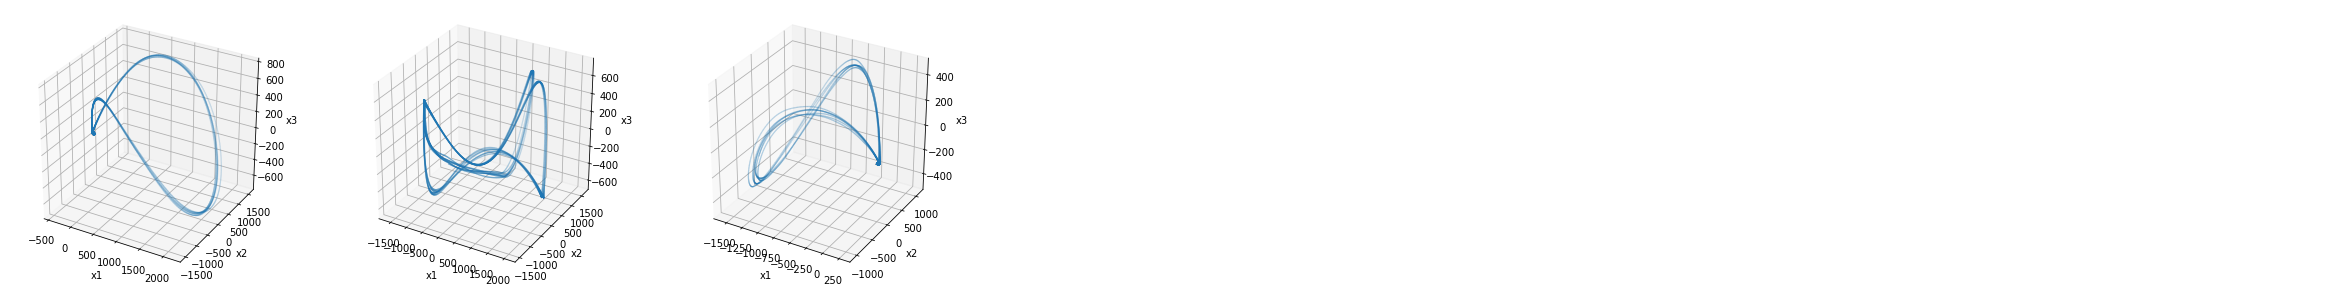

In [5]:
fig = plt.figure(figsize=(17,5))

ax = fig.add_subplot(131, projection='3d')
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel("x3")
ax.scatter(new_P1[:, 0], new_P1[:, 1], new_P1[:, 2], s=0.1, alpha=0.3)

ax = fig.add_subplot(132, projection='3d')
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel("x3")
ax.scatter(new_P2[:, 0], new_P2[:, 1], new_P2[:, 2], s=0.1, alpha=0.3)

ax = fig.add_subplot(133, projection='3d')
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel("x3")
ax.scatter(new_P3[:, 0], new_P3[:, 1], new_P3[:, 2], s=0.1, alpha=0.3)

plt.show()

# 2. Part two

## 2.1 Required functions

In [6]:
# Reduces the dimensionality of the second axis of X to target_dim.
def pca_dim_red(X, target_dim):
    #Center data.
    X = X - X.mean(axis=0)
    # Apply SVD on the data matrix.
    u, s, vh = np.linalg.svd(X, 0)
    # Dimensionality reduction.
    S = np.diag(s)
    new_X = u[:,:target_dim] @ S[:target_dim,:target_dim]
    return new_X

# Scatter-plots the principal component space values (pcs) - as
# required for the exercise - according to the first coordinate
# of their delay embedding (del_emb).
def scatter_colored(del_emb, pcs):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.set_zlabel("x3")
    ax.scatter(pcs[:, 0], pcs[:, 1], pcs[:, 2], c=del_emb[:, 0],
               s=0.3, alpha=0.3)
    plt.show()

## 2.2 Visualization

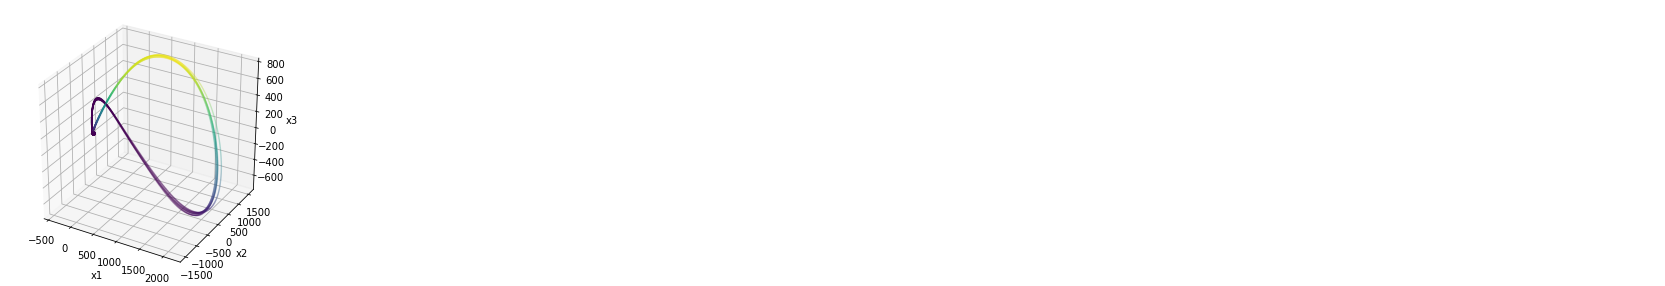

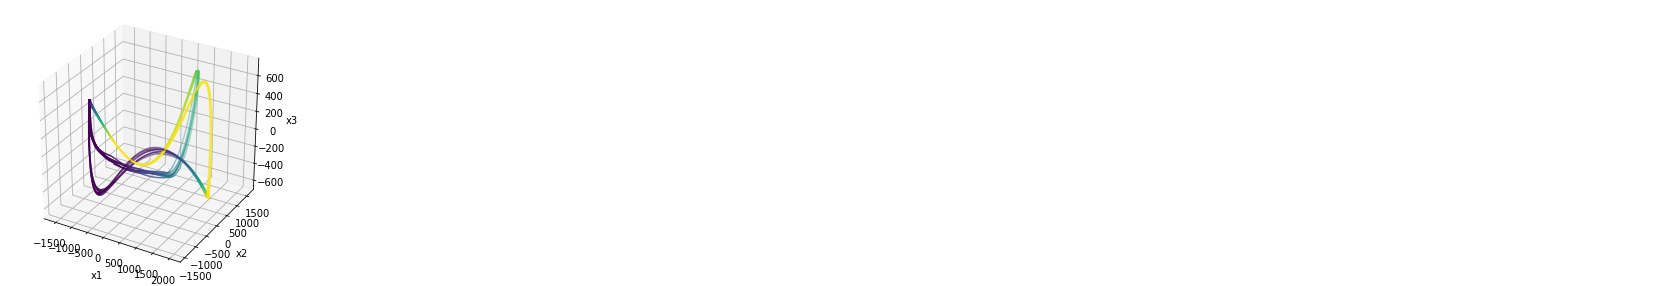

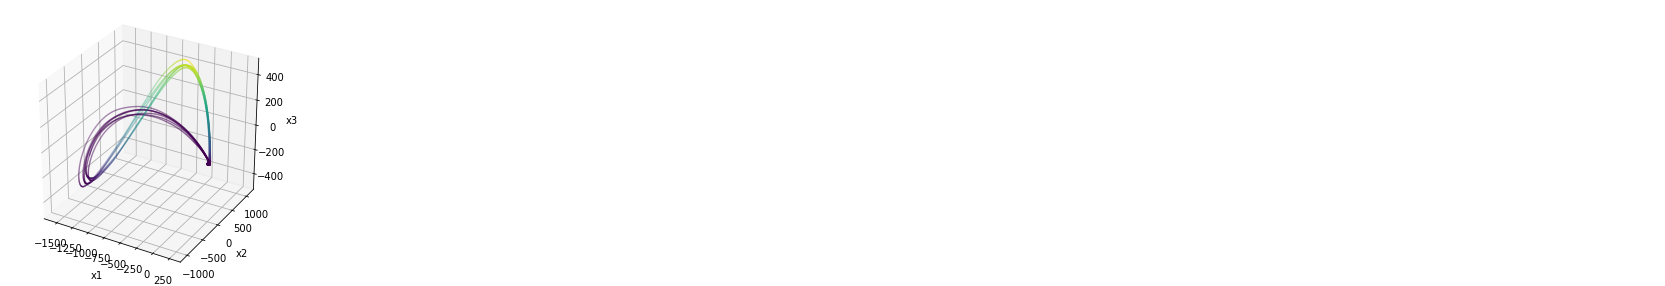

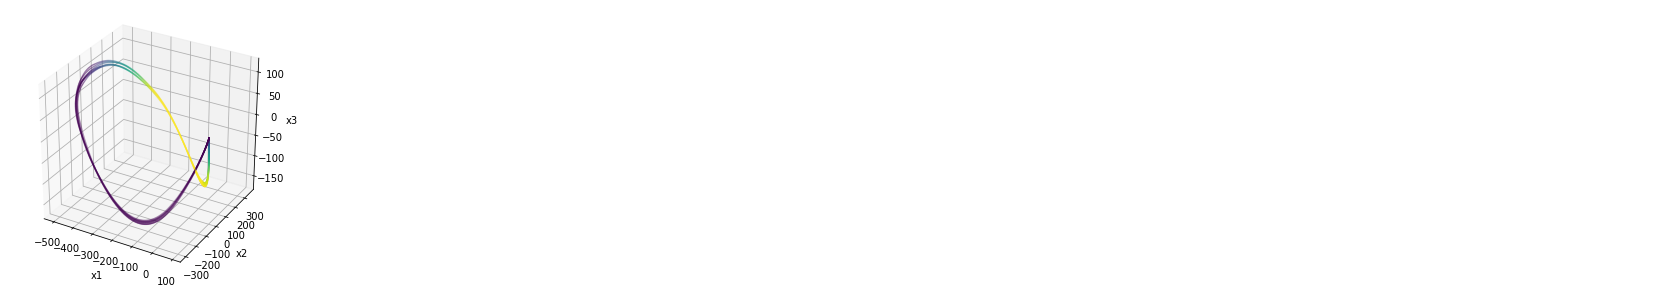

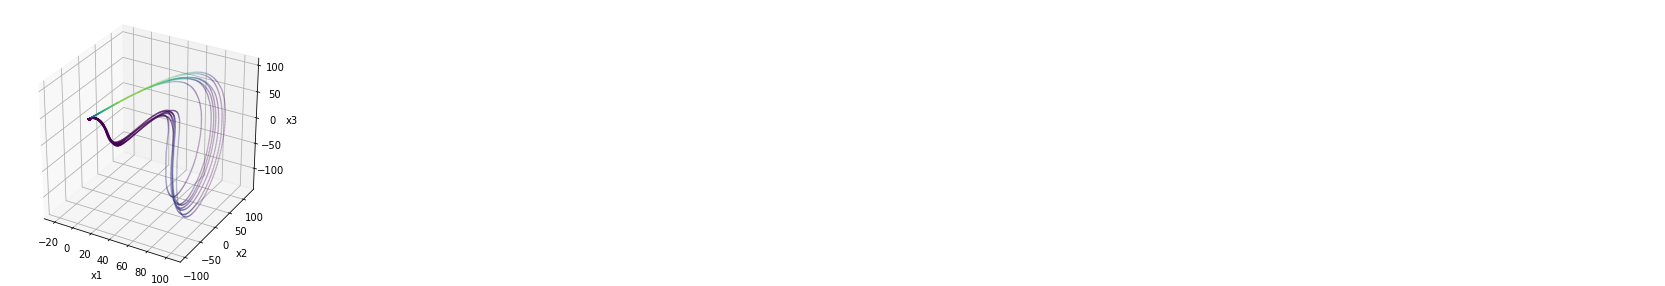

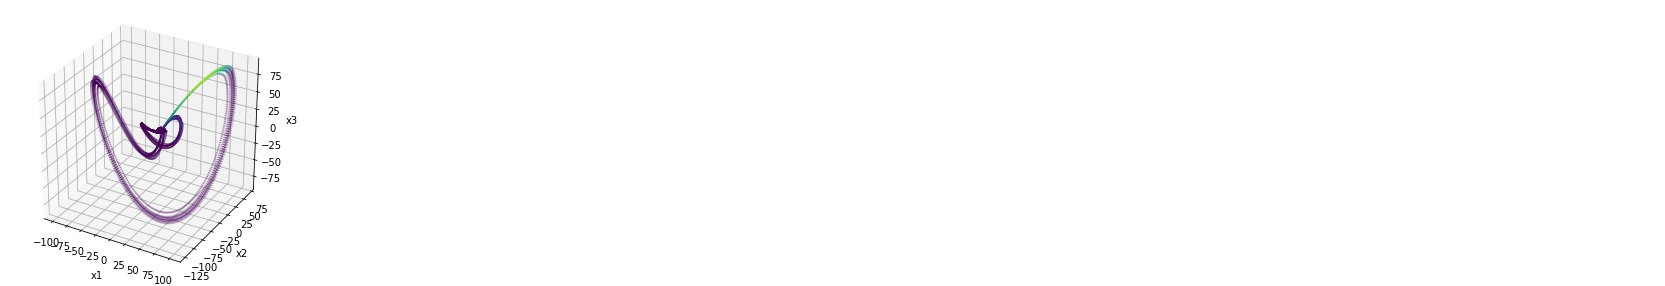

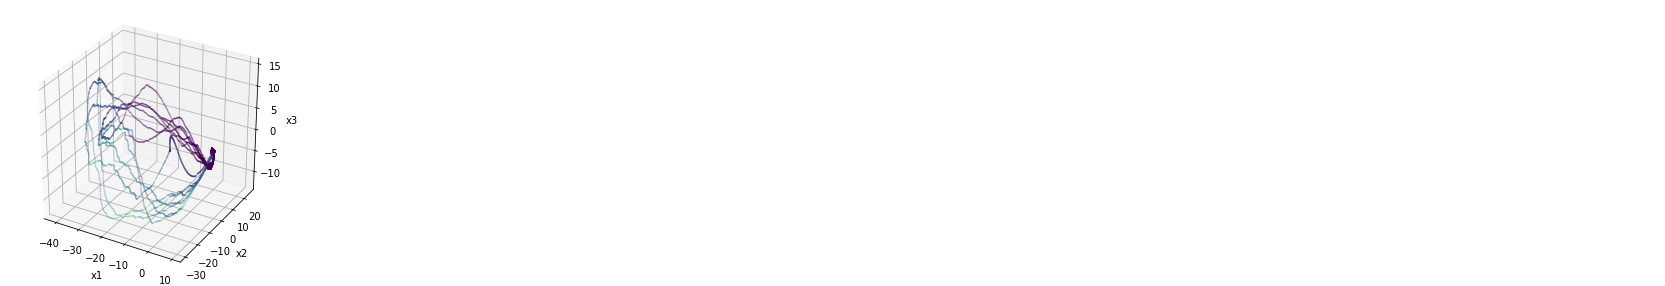

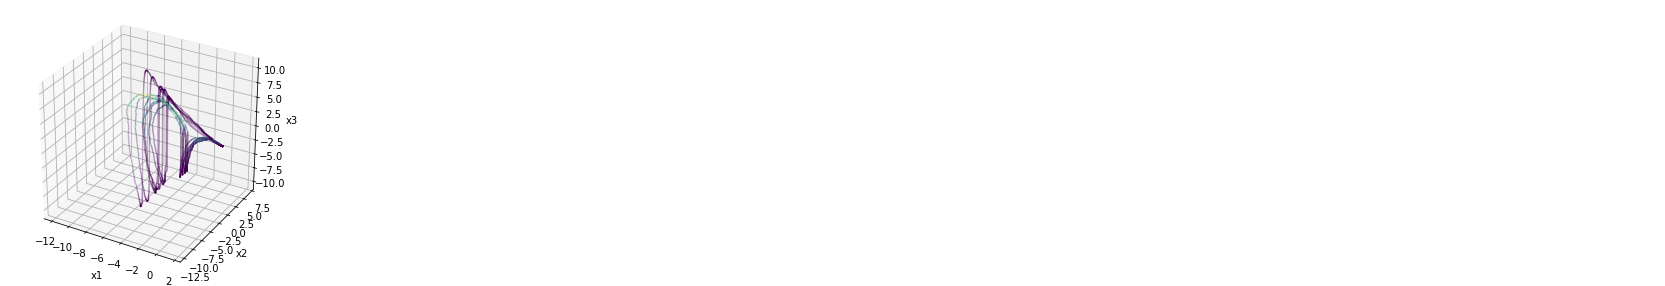

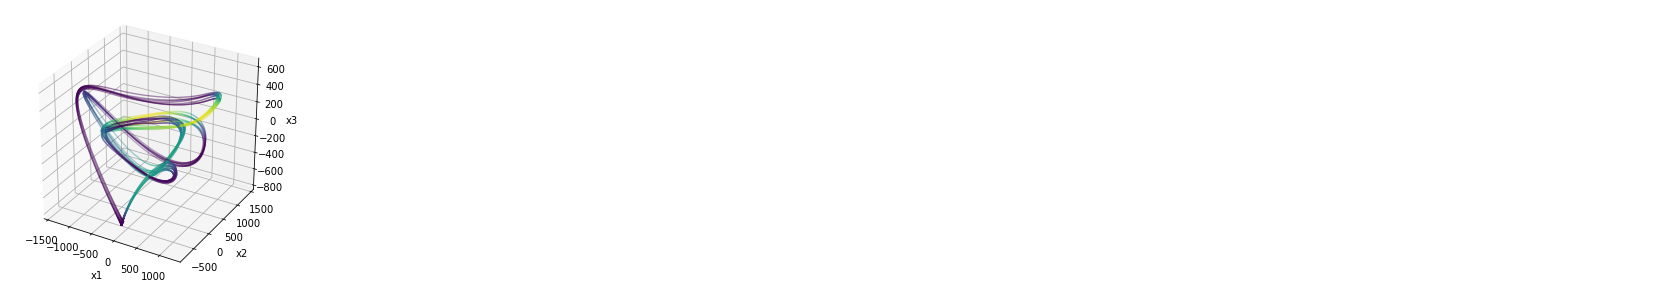

In [7]:
for i in range(1, 10):
    P = del_emb(data, i)
    pcs = pca_dim_red(P, 3)
    scatter_colored(P[:], pcs[:])

# 3. Part three & four

## 3.1 Data preparation

In [8]:
# Reduces the dimensionality of the second axis of X to target_dim.
def pca_dim_red_vh(X, target_dim):
    #Center data.
    X = X - X.mean(axis=0)
    # Apply SVD on the data matrix.
    u, s, vh = np.linalg.svd(X, 0)
    # Dimensionality reduction.
    S = np.diag(s)
    new_X = u[:,:target_dim] @ S[:target_dim,:target_dim]
    vh = vh[:target_dim, :]
    return new_X, vh

pcas_list = []
vhs_list = []
for i in range(1, 10):
    P = del_emb(data, i)
    pcs, vh = pca_dim_red_vh(P, 3)
    pcas_list.append(pcs)
    vhs_list.append(vh)

pcas = np.array(pcas_list)
vhs = np.array(vhs_list)

## 3.2 Vector field

In [9]:
areas_list = []
for i in range(pcas.shape[0]):
    arcs = []
    for j in range(pcas.shape[1]-1):
        arc = np.linalg.norm(pcas[i,j]-pcas[i,j+1])
        arcs.append(arc)
    areas_list.append(arcs)
    
# 15000 - 1000 = 14000 (original data - burn in)
# 14000 represent 7 days -> 2000 per day
# Concatenated delay arc lengths only for 13650 -> cut last day off
areas = np.array(areas_list)
areas = areas[:, :12000]
pcas_cut = pcas[:, :12000, :]

# Average arclength over the six days.
avg_arcs = np.zeros((9, 2000))
avg_pos = np.zeros((9, 2000, 3))
for i in range(6):
    avg_arcs += areas[:, i*2000:(i+1)*2000]
    avg_pos += pcas_cut[:, i*2000:(i+1)*2000, :]

avg_arcs /= 6
avg_pos /= 6

## 3.3 Prediction